In [3]:
import sys
from tardis import run_tardis
from tardis.io.atom_data.util import download_atom_data
import yaml
import copy
import time
import pprint
import numpy as np
import astropy.table as table
import json
import matplotlib.pyplot as plt

if '../lib' not in sys.path:
    sys.path.append('../lib')
import snelib19odp.specsmooth as specsmooth

def load_json_specs(fname, phase0):
    with open(fname, 'r') as f:
        data = json.load(f)
    sne = data[list(data.keys())[0]]
    specs = sne['spectra']
    redshift = float(sne['redshift'][0]['value'])
    #print(specs[1])
    ret_specs = []
    for spec in specs:
        if not 'time' in spec:
            continue
        t = spec['time']
        wave = np.array([float(x[0]) for x in spec['data']])
        flux = np.array([float(x[1]) for x in spec['data']]) 
        ret_specs.append({'time': float(t), 'phase': float(t)-phase0, 'wave': wave, 'restwave': wave/(1+redshift), 'flux': flux})
    return sorted(ret_specs, key=lambda x: x['time'])

In [4]:
ptf13bvn = load_json_specs('../data/comparison/iPTF13bvn.json', phase0=56475.0)

In [5]:
download_atom_data('kurucz_cd23_chianti_H_He')

[tardis.io.atom_data.atom_web_download][INFO   ]  Downloading atomic data from https://media.githubusercontent.com/media/tardis-sn/tardis-refdata/master/atom_data/kurucz_cd23_chianti_H_He.h5 to /home/welterde/Downloads/tardis-data/kurucz_cd23_chianti_H_He.h5 (atom_web_download.py:46)


In [6]:
# load the template config
template_conf = yaml.load(open('2021-05-24-tardis-he-template.yml'))
template_conf

[py.warnings         ][WARNING]  <ipython-input-6-bf3036b0c5d2>:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  template_conf = yaml.load(open('2021-05-24-tardis-he-template.yml'))
 (warnings.py:109)


{'tardis_config_version': 'v1.0',
 'supernova': {'luminosity_requested': '9.44 log_lsun',
  'time_explosion': '6 day'},
 'atom_data': 'kurucz_cd23_chianti_H_He.h5',
 'model': {'structure': {'type': 'specific',
   'velocity': {'start': '1.2e4 km/s', 'stop': '36000 km/s', 'num': 20},
   'density': {'type': 'branch85_w7'}},
  'abundances': {'type': 'uniform',
   'C': 0.01,
   'O': 0.01,
   'Mg': 0.01,
   'H': 0.0,
   'Ar': 0.015,
   'He': 0.95,
   'Ni56': 0.005}},
 'plasma': {'disable_electron_scattering': False,
  'ionization': 'lte',
  'excitation': 'dilute-lte',
  'radiative_rates_type': 'dilute-blackbody',
  'line_interaction_type': 'macroatom',
  'helium_treatment': 'recomb-nlte'},
 'montecarlo': {'seed': 23111963,
  'no_of_packets': 500000.0,
  'iterations': 10,
  'nthreads': 6,
  'last_no_of_packets': 1000000.0,
  'no_of_virtual_packets': 10,
  'convergence_strategy': {'type': 'damped',
   'damping_constant': 1.0,
   'threshold': 0.05,
   'fraction': 0.8,
   'hold_iterations': 3,
 

In [7]:
def genconf(v_start=1.6e4, v_stop=36000, abund={'C':0.1, 'O':0.1, 'Ni56':0.01}, t_explosion=3, inner_temp=None):
    new_conf = yaml.load(open('2021-05-24-tardis-he-template.yml'))
    new_conf['supernova']['time_explosion'] = '%d day' % t_explosion
    new_conf['model']['structure']['velocity']['start'] = '%e km/s' % v_start
    new_conf['model']['structure']['velocity']['stop'] = '%e km/s' % v_stop
    for element, fraction in abund.items():
        new_conf['model']['abundances'][element] = fraction
    del new_conf['model']['abundances']['He']
    sum_abund = sum([new_conf['model']['abundances'][x] for x in new_conf['model']['abundances'].keys() if x != 'type'])
    new_conf['model']['abundances']['He'] = 1-sum_abund
    if inner_temp is not None:
        new_conf['plasma']['initial_t_inner'] = '%f K' % inner_temp
    pprint.pprint(new_conf)
    fname = '2021-05-24-tardis-he-%d.yml' % int(time.time())
    print('Filename: ', fname)
    with open(fname, 'w') as f:
        yaml.dump(new_conf, f)
    return fname

In [9]:
cfg = genconf()
sim = run_tardis(cfg)

[py.warnings         ][WARNING]  <ipython-input-8-a4b0802d3118>:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  new_conf = yaml.load(open('2021-05-24-tardis-he-template.yml'))
 (warnings.py:109)
{'atom_data': 'kurucz_cd23_chianti_H_He.h5',
 'model': {'abundances': {'Ar': 0.015,
                          'C': 0.1,
                          'H': 0.0,
                          'He': 0.7649999999999999,
                          'Mg': 0.01,
                          'Ni56': 0.01,
                          'O': 0.1,
                          'type': 'uniform'},
           'structure': {'density': {'type': 'branch85_w7'},
                         'type': 'specific',
                         'velocity': {'num': 20,
                                      'start': '1.600000e+04 km/s',
                                      'stop': '3.600000e+04 km/s'}}},
 'montecarlo': {'converge

Running post-merge numba montecarlo (with C close lines)!
[tardis.simulation.base][INFO   ]  Luminosity emitted = 6.84011e+42 erg / s Luminosity absorbed = 2.66909e+43 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:437)
[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      25505.900096  24058.435344  1.183043  0.576344
	5      21019.429910  21218.962914  0.387282  0.140924
	10     19149.326640  19156.689481  0.199985  0.074558
	15     17906.793507  17722.971192  0.133902  0.052265

 (base.py:433)
[tardis.simulation.base][INFO   ]  t_inner 23187.938 K -- next t_inner 28855.944 K (base.py:434)
[tardis.simulation.base][INFO   ]  Starting iteration 6/10 (base.py:322)
[py.warnings         ][WARNING]  /home/welterde/anaconda3/envs/tardis/lib/python3.8/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalar

In [ ]:

spectrum = sim.runner.spectrum
spectrum_virtual = sim.runner.spectrum_virtual
spectrum_integrated = sim.runner.spectrum_integrated

figure(figsize=(10,6))
spectrum.plot(label='normal packets')
spectrum_virtual.plot(label='virtual packets')
spectrum_integrated.plot(label='formal integral')
xlabel('Wavelength [$\AA$]')
ylabel('Luminosity [erg/s/$\AA$]')
legend()
xlim(3000, 9000)

[py.warnings         ][WARNING]  /home/welterde/anaconda3/envs/tardis/lib/python3.8/site-packages/tardis_sn-3.0.dev3945-py3.8.egg/tardis/montecarlo/montecarlo_numba/formal_integral.py:275: UserWarning: The number of interpolate_shells was not specified. The value was set to 80.
  warnings.warn(
 (warnings.py:109)


(3000.0, 9000.0)

In [11]:
cfg = genconf(v_start=1.4e4)
sim = run_tardis(cfg)

[py.warnings         ][WARNING]  <ipython-input-8-a4b0802d3118>:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  new_conf = yaml.load(open('2021-05-24-tardis-he-template.yml'))
 (warnings.py:109)
{'atom_data': 'kurucz_cd23_chianti_H_He.h5',
 'model': {'abundances': {'Ar': 0.015,
                          'C': 0.1,
                          'H': 0.0,
                          'He': 0.7649999999999999,
                          'Mg': 0.01,
                          'Ni56': 0.01,
                          'O': 0.1,
                          'type': 'uniform'},
           'structure': {'density': {'type': 'branch85_w7'},
                         'type': 'specific',
                         'velocity': {'num': 20,
                                      'start': '1.400000e+04 km/s',
                                      'stop': '3.600000e+04 km/s'}}},
 'montecarlo': {'converge

Running post-merge numba montecarlo (with C close lines)!
[tardis.simulation.base][INFO   ]  Luminosity emitted = 3.40213e+42 erg / s Luminosity absorbed = 3.97670e+43 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:437)
[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      27991.444792  26001.677502  5.679540  0.682846
	5      19061.067677  17926.558515  1.961669  0.197453
	10     17418.705856  16139.113277  0.809283  0.083310
	15     15968.070367  14889.234546  0.511941  0.055340

 (base.py:433)
[tardis.simulation.base][INFO   ]  t_inner 26391.735 K -- next t_inner 46569.003 K (base.py:434)
[tardis.simulation.base][INFO   ]  Starting iteration 6/10 (base.py:322)
[py.warnings         ][WARNING]  /home/welterde/anaconda3/envs/tardis/lib/python3.8/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalar

[py.warnings         ][WARNING]  /home/welterde/anaconda3/envs/tardis/lib/python3.8/site-packages/tardis_sn-3.0.dev3945-py3.8.egg/tardis/montecarlo/montecarlo_numba/formal_integral.py:275: UserWarning: The number of interpolate_shells was not specified. The value was set to 80.
  warnings.warn(
 (warnings.py:109)


(3000.0, 9000.0)

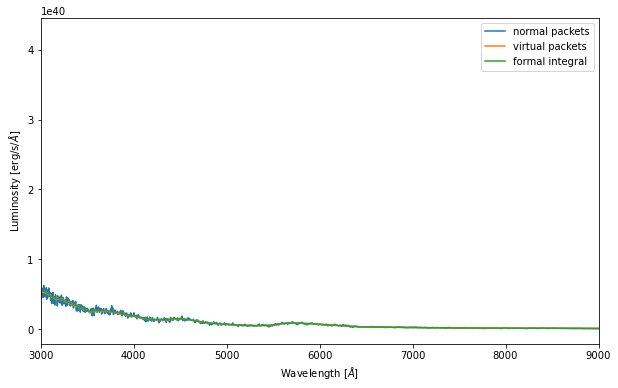

In [12]:
spectrum = sim.runner.spectrum
spectrum_virtual = sim.runner.spectrum_virtual
spectrum_integrated = sim.runner.spectrum_integrated

figure(figsize=(10,6))
spectrum.plot(label='normal packets')
spectrum_virtual.plot(label='virtual packets')
spectrum_integrated.plot(label='formal integral')
xlabel('Wavelength [$\AA$]')
ylabel('Luminosity [erg/s/$\AA$]')
legend()
xlim(3000, 9000)

In [22]:
abund={'C':0.0, 'O':0.0, 'Ni56':0.0005, 'Ar':0.00, 'Mg':0, 'Fe': 0.0005}
cfg = genconf(v_start=1.2e4, v_stop=3.6e4, abund=abund, t_explosion=2)
sim3 = run_tardis(cfg)
sim = sim3

[py.warnings         ][WARNING]  <ipython-input-7-e63bdcc02595>:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  new_conf = yaml.load(open('2021-05-24-tardis-he-template.yml'))
 (warnings.py:109)
{'atom_data': 'kurucz_cd23_chianti_H_He.h5',
 'model': {'abundances': {'Ar': 0.0,
                          'C': 0.0,
                          'Fe': 0.0005,
                          'H': 0.0,
                          'He': 0.999,
                          'Mg': 0,
                          'Ni56': 0.0005,
                          'O': 0.0,
                          'type': 'uniform'},
           'structure': {'density': {'type': 'branch85_w7'},
                         'type': 'specific',
                         'velocity': {'num': 20,
                                      'start': '1.200000e+04 km/s',
                                      'stop': '3.600000e+04 km/s'}}},
 

[tardis.simulation.base][INFO   ]  Starting iteration 4/20 (base.py:322)
[py.warnings         ][WARNING]  /home/welterde/anaconda3/envs/tardis/lib/python3.8/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:109)
Running post-merge numba montecarlo (with C close lines)!
[tardis.simulation.base][INFO   ]  Luminosity emitted = 2.78660e+43 erg / s Luminosity absorbed = 3.13999e+45 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:437)
[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      60500.830817  70988.008229  0.380218  2.193889
	5      59073.998562  52301.934507  0.011504  0.206143
	10     53313.472173  49165.360245  0.002217  0.034525
	15     51058.886358  48414.418198  0.000831  0.011315

 (base.py:433)
[tardis.simulation.base][INFO   

[tardis.simulation.base][INFO   ]  t_inner 81524.574 K -- next t_inner 79354.995 K (base.py:434)
[py.warnings         ][WARNING]  /home/welterde/anaconda3/envs/tardis/lib/python3.8/site-packages/tardis_sn-3.0.dev3945-py3.8.egg/tardis/plasma/properties/ion_population.py:175: UserWarning: t_rads outside of zeta factor interpolation zeta_min=2000.00 zeta_max=40000.00 - replacing with [67851.12145013 55244.07087331 48835.39534852 44662.48308266
 41900.03188206 39926.45394856 38352.51664917 37301.18429499
 36433.84474668 35712.41901879 35218.61810042 34664.3217383
 34358.18691498 33857.86710053 33733.15369703 33630.5868372
 33215.95174552 32920.34436476 32722.62705173 32601.84534934]
  warnings.warn(
 (warnings.py:109)
[tardis.simulation.base][INFO   ]  Starting iteration 9/20 (base.py:322)
[py.warnings         ][WARNING]  /home/welterde/anaconda3/envs/tardis/lib/python3.8/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m,

[tardis.simulation.base][INFO   ]  Starting iteration 13/20 (base.py:322)
[py.warnings         ][WARNING]  /home/welterde/anaconda3/envs/tardis/lib/python3.8/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:109)
Running post-merge numba montecarlo (with C close lines)!
[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.07268e+43 erg / s Luminosity absorbed = 1.24415e+45 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:437)
[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      67885.657814  68961.787352  1.084306  1.024521
	5      36835.723083  36230.846394  0.340766  0.364673
	10     33169.052401  32508.712646  0.064645  0.071051
	15     31104.854076  31135.900577  0.025167  0.025289

 (base.py:433)
[tardis.simulation.base][INFO  

[tardis.simulation.base][INFO   ]  t_inner 81269.965 K -- next t_inner 80725.806 K (base.py:434)
[py.warnings         ][WARNING]  /home/welterde/anaconda3/envs/tardis/lib/python3.8/site-packages/tardis_sn-3.0.dev3945-py3.8.egg/tardis/plasma/properties/ion_population.py:175: UserWarning: t_rads outside of zeta factor interpolation zeta_min=2000.00 zeta_max=40000.00 - replacing with [66864.12383022 49692.12338744 41954.44682348 37996.85678235
 35975.62932625 34583.5650887  33437.96082148 32737.04714245
 31948.04522316 31243.96619659 30867.53749005 30263.25136357
 29765.48329022 29540.65550027 29577.861127   29501.89892302
 29270.90464367 29028.26915933 28916.41907461 28568.0708195 ]
  warnings.warn(
 (warnings.py:109)
[tardis.simulation.base][INFO   ]  Starting iteration 18/20 (base.py:322)
[py.warnings         ][WARNING]  /home/welterde/anaconda3/envs/tardis/lib/python3.8/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si

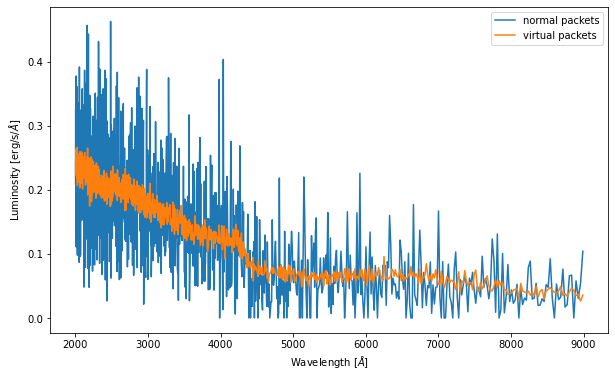

In [24]:
spectrum = sim.runner.spectrum
spectrum_virtual = sim.runner.spectrum_virtual
#spectrum_integrated = sim.runner.spectrum_integrated

plt.figure(figsize=(10,6))
wave = spectrum.wavelength.value
idx = np.logical_and(wave > 2000, wave < 9000)
plt.plot(wave[idx], spectrum.luminosity[idx]/2e40, label='normal packets')
plt.plot(wave[idx], spectrum_virtual.luminosity[idx]/2e40, label='virtual packets')

ptf_spec = ptf13bvn[1]
#plt.plot(ptf_spec['restwave'], ptf_spec['flux']/np.nanmean(ptf_spec['flux'])-3, label='PTF13bvn (phase=%.1f)' % ptf_spec['phase'])

#spectrum_virtual.plot(label='virtual packets')
#spectrum_integrated.plot(label='formal integral')
plt.xlabel('Wavelength [$\AA$]')
plt.ylabel('Luminosity [erg/s/$\AA$]')
plt.legend()
#xlim(3000, 9000)

In [25]:
abund={'C':0.1, 'O':0.1, 'Ni56':0.0005, 'Ar':0.01, 'Mg':0.01, 'Fe': 0.0005}
cfg = genconf(v_start=1.2e4, v_stop=3.6e4, abund=abund, t_explosion=2)
sim4 = run_tardis(cfg)
sim = sim4

[py.warnings         ][WARNING]  <ipython-input-7-e63bdcc02595>:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  new_conf = yaml.load(open('2021-05-24-tardis-he-template.yml'))
 (warnings.py:109)
{'atom_data': 'kurucz_cd23_chianti_H_He.h5',
 'model': {'abundances': {'Ar': 0.01,
                          'C': 0.1,
                          'Fe': 0.0005,
                          'H': 0.0,
                          'He': 0.7789999999999999,
                          'Mg': 0.01,
                          'Ni56': 0.0005,
                          'O': 0.1,
                          'type': 'uniform'},
           'structure': {'density': {'type': 'branch85_w7'},
                         'type': 'specific',
                         'velocity': {'num': 20,
                                      'start': '1.200000e+04 km/s',
                                      'stop': '3.60000

[tardis.simulation.base][INFO   ]  Starting iteration 4/20 (base.py:322)
[py.warnings         ][WARNING]  /home/welterde/anaconda3/envs/tardis/lib/python3.8/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:109)
Running post-merge numba montecarlo (with C close lines)!
[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.89639e+43 erg / s Luminosity absorbed = 2.06389e+45 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:437)
[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      74127.954096  73166.518533  0.172050  1.384032
	5      29017.210195  28879.057838  0.292043  1.331635
	10     27568.985896  27279.954278  0.047923  0.237944
	15     25564.908675  25526.371302  0.020085  0.105837

 (base.py:433)
[tardis.simulation.base][INFO   

[tardis.simulation.base][INFO   ]  t_inner 82613.527 K -- next t_inner 80283.364 K (base.py:434)
[py.warnings         ][WARNING]  /home/welterde/anaconda3/envs/tardis/lib/python3.8/site-packages/tardis_sn-3.0.dev3945-py3.8.egg/tardis/plasma/properties/ion_population.py:175: UserWarning: t_rads outside of zeta factor interpolation zeta_min=2000.00 zeta_max=40000.00 - replacing with [64151.48623643 38566.3886979  30550.05710953 28380.24404169
 27227.64021856 26383.31231564 25786.33805988 25299.29092014
 24767.3972825  24635.85769304 24602.22630482 24431.1527403
 24054.00069361 23746.08167099 23572.50793196 23029.65631673
 22751.70472462 22262.91091955 21931.32799856 21037.95692461]
  warnings.warn(
 (warnings.py:109)
[tardis.simulation.base][INFO   ]  Starting iteration 9/20 (base.py:322)
[py.warnings         ][WARNING]  /home/welterde/anaconda3/envs/tardis/lib/python3.8/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m

[tardis.simulation.base][INFO   ]  Starting iteration 13/20 (base.py:322)
[py.warnings         ][WARNING]  /home/welterde/anaconda3/envs/tardis/lib/python3.8/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:109)
Running post-merge numba montecarlo (with C close lines)!
[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.13532e+43 erg / s Luminosity absorbed = 1.29635e+45 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:437)
[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      58916.133054  57702.381632  1.985883  2.265854
	5      24290.858465  23697.763263  1.426597  1.682398
	10     22733.731876  21921.045540  0.257628  0.318538
	15     20965.548855  20126.336367  0.121937  0.154622

 (base.py:433)
[tardis.simulation.base][INFO  

[tardis.simulation.base][INFO   ]  t_inner 74115.569 K -- next t_inner 69000.970 K (base.py:434)
[py.warnings         ][WARNING]  /home/welterde/anaconda3/envs/tardis/lib/python3.8/site-packages/tardis_sn-3.0.dev3945-py3.8.egg/tardis/plasma/properties/ion_population.py:175: UserWarning: t_rads outside of zeta factor interpolation zeta_min=2000.00 zeta_max=40000.00 - replacing with [52124.75415902 18122.96970883 15666.73067637 15299.52512107
 16118.28323374 16698.12737593 16835.9951386  16666.89147582
 16314.1040543  15998.92644571 15837.9273371  15471.81515625
 15275.84036035 14951.23903343 14656.81222211 14506.40660712
 14272.20383779 14149.40469482 13865.3806029  13630.4474234 ]
  warnings.warn(
 (warnings.py:109)
[tardis.simulation.base][INFO   ]  Starting iteration 18/20 (base.py:322)
[py.warnings         ][WARNING]  /home/welterde/anaconda3/envs/tardis/lib/python3.8/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si

[py.warnings         ][WARNING]  /home/welterde/anaconda3/envs/tardis/lib/python3.8/site-packages/astropy/units/quantity.py:464: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
 (warnings.py:109)
[py.warnings         ][WARNING]  /home/welterde/anaconda3/envs/tardis/lib/python3.8/site-packages/astropy/units/quantity.py:464: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
 (warnings.py:109)


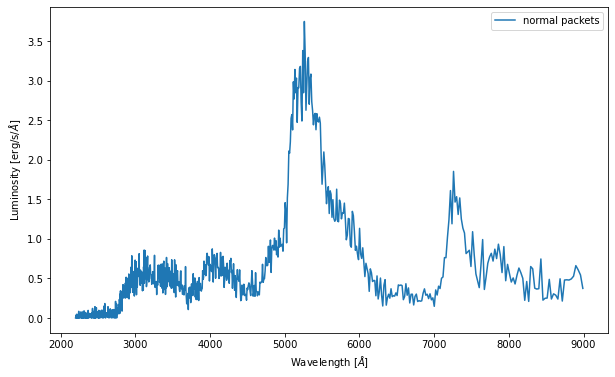

In [28]:
spectrum = sim.runner.spectrum
spectrum_virtual = sim.runner.spectrum_virtual
#spectrum_integrated = sim.runner.spectrum_integrated

plt.figure(figsize=(10,6))
wave = spectrum.wavelength.value
idx = np.logical_and(wave > 2200, wave < 9000)
plt.plot(wave[idx], spectrum.luminosity[idx]/2e40, label='normal packets')
#plt.plot(wave[idx], spectrum_virtual.luminosity[idx]/2e40, label='virtual packets')

ptf_spec = ptf13bvn[1]
#plt.plot(ptf_spec['restwave'], ptf_spec['flux']/np.nanmean(ptf_spec['flux'])-3, label='PTF13bvn (phase=%.1f)' % ptf_spec['phase'])

#spectrum_virtual.plot(label='virtual packets')
#spectrum_integrated.plot(label='formal integral')
plt.xlabel('Wavelength [$\AA$]')
plt.ylabel('Luminosity [erg/s/$\AA$]')
plt.legend()
#xlim(3000, 9000)

In [37]:
abund={'C':0.1, 'O':0.1, 'Ni56':0.0005, 'Ar':0.01, 'Mg':0.01, 'Fe': 0.0005}
cfg = genconf(v_start=1.4e4, v_stop=3.6e4, abund=abund, t_explosion=2)
sim4 = run_tardis(cfg)
sim = sim4

[py.warnings         ][WARNING]  <ipython-input-7-e63bdcc02595>:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  new_conf = yaml.load(open('2021-05-24-tardis-he-template.yml'))
 (warnings.py:109)
{'atom_data': 'kurucz_cd23_chianti_H_He.h5',
 'model': {'abundances': {'Ar': 0.01,
                          'C': 0.1,
                          'Fe': 0.0005,
                          'H': 0.0,
                          'He': 0.7789999999999999,
                          'Mg': 0.01,
                          'Ni56': 0.0005,
                          'O': 0.1,
                          'type': 'uniform'},
           'structure': {'density': {'type': 'branch85_w7'},
                         'type': 'specific',
                         'velocity': {'num': 20,
                                      'start': '1.400000e+04 km/s',
                                      'stop': '3.60000

[py.warnings         ][WARNING]  /home/welterde/anaconda3/envs/tardis/lib/python3.8/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:109)
Running post-merge numba montecarlo (with C close lines)!
[tardis.simulation.base][INFO   ]  Luminosity emitted = 7.16952e+42 erg / s Luminosity absorbed = 2.40772e+44 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:437)
[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      34142.178305  33107.166150  7.184175  3.189663
	5      22608.249570  21556.227172  1.931630  0.816331
	10     20819.328870  19878.770625  0.585219  0.232687
	15     19403.004930  18396.731089  0.312962  0.127996

 (base.py:433)
[tardis.simulation.base][INFO   ]  t_inner 50044.553 K -- next t_inner 58672.739 K (base.py:434)
[tardis.

[tardis.simulation.base][INFO   ]  Starting iteration 12/20 (base.py:322)
[py.warnings         ][WARNING]  /home/welterde/anaconda3/envs/tardis/lib/python3.8/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:109)
Running post-merge numba montecarlo (with C close lines)!
[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.07610e+43 erg / s Luminosity absorbed = 3.19794e+44 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:437)
[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w     next_w
	Shell                                                 
	0      34941.115867  35161.539913  3.209151   3.232596
	5      14704.178684  12094.648645  4.758533  10.794535
	10     13741.218491  11067.051499  1.406277   3.273764
	15     12556.049531   9956.854142  0.814709   2.037584

 (base.py:433)
[tardis.simulation.base][

[tardis.simulation.base][INFO   ]  t_inner 57257.238 K -- next t_inner 56983.178 K (base.py:434)
[tardis.simulation.base][INFO   ]  Starting iteration 19/20 (base.py:322)
[py.warnings         ][WARNING]  /home/welterde/anaconda3/envs/tardis/lib/python3.8/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:109)
Running post-merge numba montecarlo (with C close lines)!
[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.02405e+43 erg / s Luminosity absorbed = 4.07619e+44 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:437)
[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad          w     next_w
	Shell                                                  
	0      29942.647445  29559.664286   7.647969   7.905244
	5       7368.918355   7331.886129  93.897925  90.769459
	10      6161.512744   6238.610207  35.451884  32.08

In [36]:
spectrum = sim.runner.spectrum
spectrum_virtual = sim.runner.spectrum_virtual
#spectrum_integrated = sim.runner.spectrum_integrated

plt.figure(figsize=(10,6))
wave = spectrum.wavelength.value
idx = np.logical_and(wave > 2000, wave < 9000)
sim_peak = np.percentile(spectrum_virtual.luminosity[idx], 95)
print(sim_peak)
plt.plot(wave[idx], spectrum.luminosity[idx]/sim_peak, label='normal packets')
plt.plot(wave[idx], spectrum_virtual.luminosity[idx]/sim_peak, label='virtual packets')

ptf_spec = ptf13bvn[1]
#plt.plot(ptf_spec['restwave'], ptf_spec['flux']/np.nanmean(ptf_spec['flux'])-3, label='PTF13bvn (phase=%.1f)' % ptf_spec['phase'])

#spectrum_virtual.plot(label='virtual packets')
#spectrum_integrated.plot(label='formal integral')
plt.xlabel('Wavelength [$\AA$]')
plt.ylabel('Luminosity [erg/s/$\AA$]')
plt.legend()
#xlim(3000, 9000)

inf
[py.warnings         ][WARNING]  /home/welterde/anaconda3/envs/tardis/lib/python3.8/site-packages/astropy/units/quantity.py:464: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
 (warnings.py:109)


In [13]:
abund={'C':0.3, 'O':0.3, 'Ni56':0.00, 'Ar':0.00, 'Mg':0}
cfg = genconf(v_start=1.75e4, v_stop=3.6e4, abund=abund, t_explosion=2)
sim5 = run_tardis(cfg)
sim = sim5

[py.warnings         ][WARNING]  <ipython-input-7-e63bdcc02595>:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  new_conf = yaml.load(open('2021-05-24-tardis-he-template.yml'))
 (warnings.py:109)
{'atom_data': 'kurucz_cd23_chianti_H_He.h5',
 'model': {'abundances': {'Ar': 0.0,
                          'C': 0.3,
                          'H': 0.0,
                          'He': 0.4,
                          'Mg': 0,
                          'Ni56': 0.0,
                          'O': 0.3,
                          'type': 'uniform'},
           'structure': {'density': {'type': 'branch85_w7'},
                         'type': 'specific',
                         'velocity': {'num': 20,
                                      'start': '1.750000e+04 km/s',
                                      'stop': '3.600000e+04 km/s'}}},
 'montecarlo': {'convergence_strategy': {'damp

Running post-merge numba montecarlo (with C close lines)!
[tardis.simulation.base][INFO   ]  Luminosity emitted = 6.39792e+42 erg / s Luminosity absorbed = 2.32140e+43 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:437)
[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      30174.381882  27127.356054  0.953158  0.631459
	5      26402.959582  26110.001215  0.340270  0.138026
	10     25006.610647  25028.137542  0.168212  0.060765
	15     23921.248769  23997.353733  0.105658  0.036511

 (base.py:433)
[tardis.simulation.base][INFO   ]  t_inner 26365.059 K -- next t_inner 32412.636 K (base.py:434)
[tardis.simulation.base][INFO   ]  Starting iteration 6/10 (base.py:322)
[py.warnings         ][WARNING]  /home/welterde/anaconda3/envs/tardis/lib/python3.8/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalar

7.172653932103288e+39


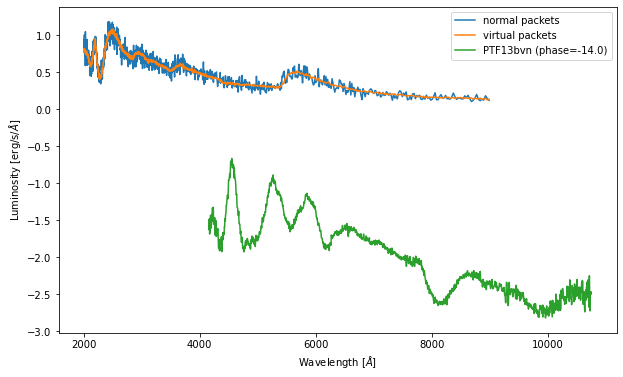

In [15]:
spectrum = sim.runner.spectrum
spectrum_virtual = sim.runner.spectrum_virtual
#spectrum_integrated = sim.runner.spectrum_integrated

plt.figure(figsize=(10,6))
wave = spectrum.wavelength.value
idx = np.logical_and(wave > 2000, wave < 9000)
sim_peak = np.percentile(spectrum_virtual.luminosity[idx], 95)
print(sim_peak)
plt.plot(wave[idx], spectrum.luminosity[idx]/sim_peak, label='normal packets')
plt.plot(wave[idx], spectrum_virtual.luminosity[idx]/sim_peak, label='virtual packets')

ptf_spec = ptf13bvn[1]
plt.plot(ptf_spec['restwave'], ptf_spec['flux']/np.nanmean(ptf_spec['flux'])-3, label='PTF13bvn (phase=%.1f)' % ptf_spec['phase'])

#spectrum_virtual.plot(label='virtual packets')
#spectrum_integrated.plot(label='formal integral')
plt.xlabel('Wavelength [$\AA$]')
plt.ylabel('Luminosity [erg/s/$\AA$]')
plt.legend()
#xlim(3000, 9000)

In [62]:
abund={'C':0.01, 'O':0.01, 'Ni56':0.0, 'Ar':0.01, 'Mg':0.01}
cfg = genconf(v_start=1.2e4, v_stop=3.6e4, abund=abund, t_explosion=6)
sim8 = run_tardis(cfg)
sim = sim8

[py.warnings         ][WARNING]  <ipython-input-8-a4b0802d3118>:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  new_conf = yaml.load(open('2021-05-24-tardis-he-template.yml'))
 (warnings.py:109)
{'atom_data': 'kurucz_cd23_chianti_H_He.h5',
 'model': {'abundances': {'Ar': 0.01,
                          'C': 0.01,
                          'H': 0.0,
                          'He': 0.96,
                          'Mg': 0.01,
                          'Ni56': 0.0,
                          'O': 0.01,
                          'type': 'uniform'},
           'structure': {'density': {'type': 'branch85_w7'},
                         'type': 'specific',
                         'velocity': {'num': 20,
                                      'start': '1.200000e+04 km/s',
                                      'stop': '3.600000e+04 km/s'}}},
 'montecarlo': {'convergence_strategy':

Running post-merge numba montecarlo (with C close lines)!
[tardis.simulation.base][INFO   ]  Luminosity emitted = 3.05952e+42 erg / s Luminosity absorbed = 8.77249e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:437)
[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      23645.449358  15354.268473  1.019214  0.482816
	5      21342.430450  15855.460282  0.161016  0.040417
	10     20176.494495  15285.154237  0.072429  0.016799
	15     19121.027067  14614.975600  0.046748  0.010680

 (base.py:433)
[tardis.simulation.base][INFO   ]  t_inner 14545.054 K -- next t_inner 27064.074 K (base.py:434)
[tardis.simulation.base][INFO   ]  Starting iteration 6/10 (base.py:322)
[py.warnings         ][WARNING]  /home/welterde/anaconda3/envs/tardis/lib/python3.8/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalar

1.8969665363512318e+40


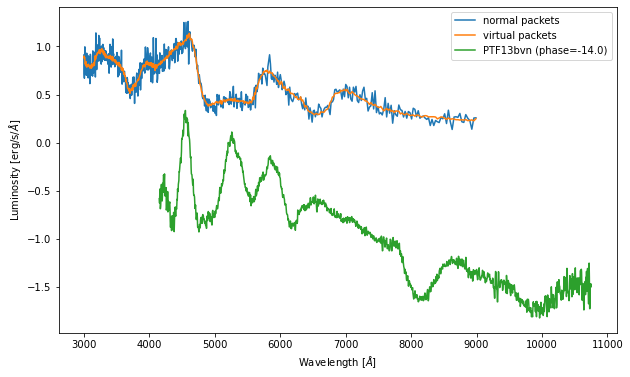

In [64]:
spectrum = sim.runner.spectrum
spectrum_virtual = sim.runner.spectrum_virtual
#spectrum_integrated = sim.runner.spectrum_integrated

figure(figsize=(10,6))
wave = spectrum.wavelength.value
idx = np.logical_and(wave > 3000, wave < 9000)
sim_peak = np.percentile(spectrum_virtual.luminosity[idx], 95)
print(sim_peak)
plt.plot(wave[idx], spectrum.luminosity[idx]/sim_peak, label='normal packets')
plt.plot(wave[idx], spectrum_virtual.luminosity[idx]/sim_peak, label='virtual packets')

ptf_spec = ptf13bvn[1]
plt.plot(ptf_spec['restwave'], ptf_spec['flux']/np.nanmean(ptf_spec['flux'])-2, label='PTF13bvn (phase=%.1f)' % ptf_spec['phase'])

#spectrum_virtual.plot(label='virtual packets')
#spectrum_integrated.plot(label='formal integral')
xlabel('Wavelength [$\AA$]')
ylabel('Luminosity [erg/s/$\AA$]')
legend()
#xlim(3000, 9000)

In [73]:
abund={'C':0.01, 'O':0.01, 'Ni56':0.0, 'Ar':0.01, 'Mg':0.01}
cfg = genconf(v_start=1.2e4, v_stop=3.6e4, abund=abund, t_explosion=6, inner_temp=15e3)
sim9 = run_tardis(cfg)
sim = sim9

[py.warnings         ][WARNING]  <ipython-input-67-e63bdcc02595>:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  new_conf = yaml.load(open('2021-05-24-tardis-he-template.yml'))
 (warnings.py:109)
{'atom_data': 'kurucz_cd23_chianti_H_He.h5',
 'model': {'abundances': {'Ar': 0.01,
                          'C': 0.01,
                          'H': 0.0,
                          'He': 0.96,
                          'Mg': 0.01,
                          'Ni56': 0.0,
                          'O': 0.01,
                          'type': 'uniform'},
           'structure': {'density': {'type': 'branch85_w7'},
                         'type': 'specific',
                         'velocity': {'num': 20,
                                      'start': '1.200000e+04 km/s',
                                      'stop': '3.600000e+04 km/s'}}},
 'montecarlo': {'convergence_strategy'

[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.12996e+42 erg / s Luminosity absorbed = 3.74206e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:437)
[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      24621.875657  12789.931809  1.278234  0.401412
	5      21588.085207  13526.230359  0.225627  0.027751
	10     20359.054549  13198.716677  0.102653  0.010904
	15     19233.718076  12461.538716  0.066841  0.007288

 (base.py:433)
[tardis.simulation.base][INFO   ]  t_inner 11647.744 K -- next t_inner 38064.312 K (base.py:434)
[tardis.simulation.base][INFO   ]  Starting iteration 6/10 (base.py:322)
[py.warnings         ][WARNING]  /home/welterde/anaconda3/envs/tardis/lib/python3.8/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.p

1.2501530289748994e+42


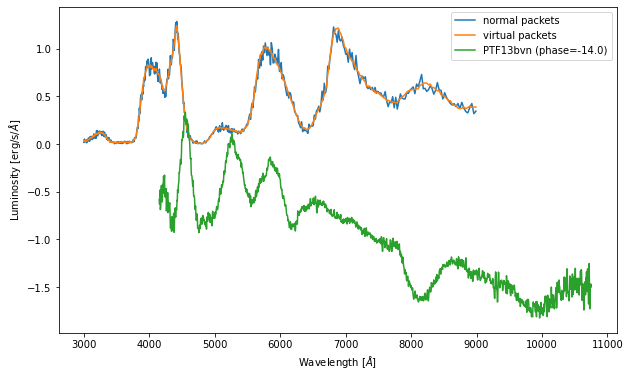

In [69]:
spectrum = sim.runner.spectrum
spectrum_virtual = sim.runner.spectrum_virtual
#spectrum_integrated = sim.runner.spectrum_integrated

figure(figsize=(10,6))
wave = spectrum.wavelength.value
idx = np.logical_and(wave > 3000, wave < 9000)
sim_peak = np.percentile(spectrum_virtual.luminosity[idx], 95)
print(sim_peak)
plt.plot(wave[idx], spectrum.luminosity[idx]/sim_peak, label='normal packets')
plt.plot(wave[idx], spectrum_virtual.luminosity[idx]/sim_peak, label='virtual packets')

ptf_spec = ptf13bvn[1]
plt.plot(ptf_spec['restwave'], ptf_spec['flux']/np.nanmean(ptf_spec['flux'])-2, label='PTF13bvn (phase=%.1f)' % ptf_spec['phase'])

#spectrum_virtual.plot(label='virtual packets')
#spectrum_integrated.plot(label='formal integral')
xlabel('Wavelength [$\AA$]')
ylabel('Luminosity [erg/s/$\AA$]')
legend()
#xlim(3000, 9000)